In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  1.11 ; cuda:  1.11.0
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets import load_coco_json
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
%matplotlib inline

from MyTrainer import MyTrainer

In [3]:
dataset_dir = os.path.join('land_segmentation_coco_dataset')
train_dataset_dir = os.path.join(dataset_dir, 'train')
train_images_dir = os.path.join(train_dataset_dir, 'images')
train_annotations_dir = os.path.join(train_dataset_dir, 'land_segmentation_coco.json')
val_dataset_dir = os.path.join(dataset_dir, 'val')
val_images_dir = os.path.join(val_dataset_dir, 'images')
val_annotations_dir = os.path.join(val_dataset_dir, 'land_segmentation_coco.json')

In [4]:
from pycocotools.coco import COCO

def validate_annotations(json_file):
    coco_api = COCO(json_file)
    img_ids = sorted(coco_api.imgs.keys())
    imgs = coco_api.loadImgs(img_ids)
    anns = [coco_api.imgToAnns[img_id] for img_id in img_ids]
    total_num_valid_anns = sum([len(x) for x in anns])
    total_num_anns = len(coco_api.anns)
    print('total_num_valid_anns:', total_num_valid_anns)
    print('total_num_anns:', total_num_anns)
    if total_num_valid_anns < total_num_anns:
        print(f"{json_file} contains {total_num_anns} annotations, but only ")
        print(f"{total_num_valid_anns} of them match to images in the file.")
    else:
        print(f"All the annotations in {json_file} are valid")

In [5]:
validate_annotations(train_annotations_dir)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
total_num_valid_anns: 11535
total_num_anns: 11535
All the annotations in land_segmentation_coco_dataset/train/land_segmentation_coco.json are valid


In [6]:
validate_annotations(val_annotations_dir)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
total_num_valid_anns: 2390
total_num_anns: 2390
All the annotations in land_segmentation_coco_dataset/val/land_segmentation_coco.json are valid


In [7]:
register_coco_instances(name="land_segmentation_train", metadata={}, json_file=train_annotations_dir, image_root=train_images_dir)
register_coco_instances(name="land_segmentation_val", metadata={}, json_file=val_annotations_dir, image_root=val_images_dir)
land_segmentation_metadata = MetadataCatalog.get("land_segmentation_train")
land_segmentation_metadata.thing_colors = [(245,147,49),(178,80,80),(52,209,183),(61,245,61)]
print(land_segmentation_metadata)

Metadata(name='land_segmentation_train', json_file='land_segmentation_coco_dataset/train/land_segmentation_coco.json', image_root='land_segmentation_coco_dataset/train/images', evaluator_type='coco', thing_colors=[(245, 147, 49), (178, 80, 80), (52, 209, 183), (61, 245, 61)])


WARNING [06/28 08:31:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 08:31:34 d2.data.datasets.coco]: Loaded 15679 images in COCO format from land_segmentation_coco_dataset/train/land_segmentation_coco.json
land_segmentation_coco_dataset/train/images/L18B10D2C_crop_351.tif


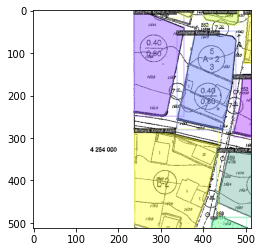


land_segmentation_coco_dataset/train/images/L40B25A2A_crop_1317.jpg


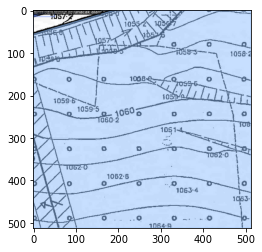


land_segmentation_coco_dataset/train/images/K19C12A2A_crop_6.jpg


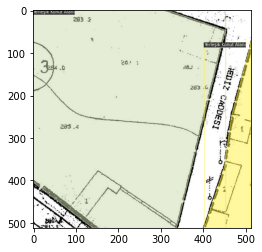

In [8]:
dicts = load_coco_json(train_annotations_dir, train_images_dir, 'land_segmentation_train')
for d in random.sample(dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=land_segmentation_metadata, scale=0.5, instance_mode=ColorMode.SEGMENTATION)
    out = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    print()

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("land_segmentation_train",)
cfg.DATASETS.TEST = ("land_segmentation_val",)
cfg.TEST.EVAL_PERIOD = 10
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 20#00    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

config_save_path = os.path.join(cfg.OUTPUT_DIR, 'config.yaml')
with open(config_save_path, "w") as f: 
    f.write(cfg.dump())

[06/28 08:32:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[06/28 08:32:07 d2.engine.train_loop]: Starting training from iteration 0


/home/ubuntu/anaconda3/envs/detectron/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755888534/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


WARNING [06/28 08:32:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 08:32:49 d2.data.datasets.coco]: Loaded 485 images in COCO format from land_segmentation_coco_dataset/val/land_segmentation_coco.json
[06/28 08:32:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/28 08:32:49 d2.data.common]: Serializing 485 elements to byte tensors and concatenating them all ...
[06/28 08:32:49 d2.data.common]: Serialized dataset takes 0.34 MiB
##########
######
WARNING [06/28 08:32:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/28 08:32:49 d2.evaluation.evaluator]: Start inference on 485 batches
[06/28 08:32:55 d2.evaluation.evaluator]: Inference done 11/485. Dataloading: 0.0012 s/iter. Inference: 0.052

In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 2195), started 0:53:27 ago. (Use '!kill 2195' to kill it.)

In [19]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/28 08:42:05 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [20]:
land_segmentation_metadata = MetadataCatalog.get("land_segmentation_val")
land_segmentation_metadata.thing_colors = [(245,147,49),(178,80,80),(52,209,183),(61,245,61)]
print(land_segmentation_metadata)

Metadata(name='land_segmentation_val', json_file='land_segmentation_coco_dataset/val/land_segmentation_coco.json', image_root='land_segmentation_coco_dataset/val/images', evaluator_type='coco', thing_classes=['Tarımsal niteliği korunacak alan', 'Gelişme Konut Alanı', 'Yerleşik Konut Alanı', 'Park'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3}, thing_colors=[(245, 147, 49), (178, 80, 80), (52, 209, 183), (61, 245, 61)])


WARNING [06/28 08:42:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 08:42:05 d2.data.datasets.coco]: Loaded 15679 images in COCO format from land_segmentation_coco_dataset/train/land_segmentation_coco.json
land_segmentation_coco_dataset/train/images/L40B20D3C_crop_1274.jpg


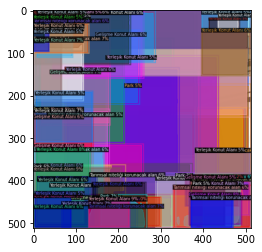



land_segmentation_coco_dataset/train/images/L40B25B1D_crop_234.jpg


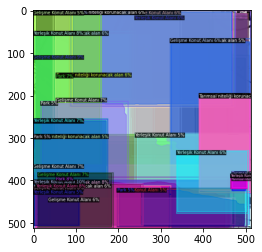



land_segmentation_coco_dataset/train/images/K19C12A2A_crop_2172.jpg


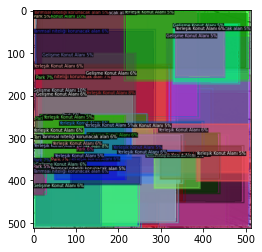

In [21]:
dicts = load_coco_json(train_annotations_dir, train_images_dir, 'land_segmentation_val')
for d in random.sample(dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=land_segmentation_metadata, 
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d["file_name"])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    print('\n')

In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("land_segmentation_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "land_segmentation_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [06/28 08:42:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 08:42:19 d2.data.datasets.coco]: Loaded 485 images in COCO format from land_segmentation_coco_dataset/val/land_segmentation_coco.json
[06/28 08:42:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/28 08:42:19 d2.data.common]: Serializing 485 elements to byte tensors and concatenating them all ...
[06/28 08:42:19 d2.data.common]: Serialized dataset takes 0.34 MiB
[06/28 08:42:19 d2.evaluation.evaluator]: Start inference on 485 batches
[06/28 08:42:23 d2.evaluation.evaluator]: Inference done 11/485. Dataloading: 0.0012 s/iter. Inference: 0.0469 s/iter. Eval: 0.1957 s/iter. Total: 0.2439 s/iter. ETA=0:01:55
[06/28 08:42:28 d2.evaluation.evaluator]: Inference done 30/485. Dataloading: 0.0014 s/iter. Inference: 0.0450 s/iter. Eval

KeyboardInterrupt: 